Đề tài: phát hiện url độc hại bằng phương pháp học sâu

## Khai báo thư viện

In [22]:
import pandas as pd
import numpy as np
import os
import pickle
import tensorflow as tf
import tensorflow.keras as keras
from urllib.parse import urlparse
import tldextract
from tld import get_tld, is_tld

import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split

from keras.layers import BatchNormalization, Dropout, LSTM, Conv1D, AveragePooling1D, InputLayer, GlobalAveragePooling1D, SpatialDropout1D

In [4]:
from tensorflow.keras.layers import  Embedding, Flatten, Dense,Dropout, Lambda
from tensorflow.keras.models import  Sequential

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
!pip show tensorflow

Name: tensorflow
Version: 2.15.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine-rl


In [1]:
!pip install tld

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.8/263.8 kB 2.4 MB/s eta 0:00:00


In [2]:
!pip install tldextract

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.7/97.7 kB 2.5 MB/s eta 0:00:00


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
label=['benign', 'defacement', 'malware', 'phishing', 'spam']

## Thêm dữ liệu

In [ ]:
big_data=pd.read_csv('/content/drive/MyDrive/dataset/BIG_DATA.csv')
big_data.head(10)

,Unnamed: 0,url,type_name,type,url_len,domain,@,?,-,=,...,!,*,",",//,abnormal_url,https,digits,letters,shortening_service,contain_ip_address
0,0,http://www.zselicpaintball.hu/index.html,DefacementSitesURLFiltered,1,40,www.zselicpaintball.hu,0,0,0,0,...,0,0,0,1,1,0,0,33,0,0
1,1,http://sohacogroup.com.vn/index.php?option=com...,DefacementSitesURLFiltered,1,100,sohacogroup.com.vn,0,1,0,4,...,0,0,0,1,1,0,5,77,0,0
2,2,http://indianexpress.com/article/cities/mumbai...,Benign_list_big_final,0,116,indianexpress.com,0,0,9,0,...,0,0,0,1,1,0,0,98,0,0
3,3,http://www.easy-process.de/de/eigenes-wissensm...,DefacementSitesURLFiltered,1,60,www.easy-process.de,0,0,2,0,...,0,0,0,1,1,0,0,50,0,0
4,4,http://mic.com/articles/105628/10-uplifting-ph...,Benign_list_big_final,0,99,mic.com,0,0,12,0,...,0,0,0,1,1,0,12,68,0,0
5,5,http://www.marrrceloandrade.com.br/index.php?o...,DefacementSitesURLFiltered,1,183,www.marrrceloandrade.com.br,0,1,10,5,...,0,0,0,1,1,0,6,146,0,0
6,6,http://www.corpussportcenter.it/includes/index...,phishing_dataset,3,51,www.corpussportcenter.it,0,0,0,0,...,0,0,0,1,1,0,0,43,0,0
7,7,http://www.mariolas.gr/sejeal.jpg,DefacementSitesURLFiltered,1,33,www.mariolas.gr,0,0,0,0,...,0,0,0,1,1,0,0,26,0,0
8,8,http://www.aiavicenza.it/index.php?option=com_...,DefacementSitesURLFiltered,1,160,www.aiavicenza.it,0,1,9,4,...,0,0,0,1,1,0,4,129,0,0
9,9,http://mixi.jp/share.pl?u=http://alfalfalfa.co...,Benign_list_big_final,0,111,mixi.jp,0,1,0,2,...,0,0,0,2,1,0,31,63,0,0


In [ ]:
big_data.shape

(165366, 25)

In [ ]:
big_data2=pd.read_csv('/content/drive/MyDrive/dataset/urldata.csv')
big_data2.head(10)

,Unnamed: 0,url,label,result
0,0,https://www.google.com,benign,0
1,1,https://www.youtube.com,benign,0
2,2,https://www.facebook.com,benign,0
3,3,https://www.baidu.com,benign,0
4,4,https://www.wikipedia.org,benign,0
5,5,https://www.reddit.com,benign,0
6,6,https://www.yahoo.com,benign,0
7,7,https://www.google.co.in,benign,0
8,8,https://www.qq.com,benign,0
9,9,https://www.amazon.com,benign,0


In [ ]:
big_data2.shape

(450176, 4)

In [ ]:
big_data2=big_data2[big_data2['label']=='benign'].sample(frac=1).reset_index(drop=True)
big_data2

,Unnamed: 0,url,label,result
0,152298,https://www.boardsgalore.com/PaulaStAmour.htm,benign,0
1,180198,https://www.emusic.com/album/Za%C3%AFko-Langa-...,benign,0
2,160380,https://www.celebrityskinblog.com/?p=77,benign,0
3,283384,https://www.rootsweb.ancestry.com/~mobarry/cem...,benign,0
4,311364,https://www.tuchmancleaners.com/locations/,benign,0
...,...,...,...,...
345733,16811,https://www.chou.med.harvard.edu/publication.htm,benign,0
345734,27669,https://www.en-gb.facebook.com/scott.bonner,benign,0
345735,209839,https://www.hermanagencyinc.com/elisabeth_pasc...,benign,0
345736,264253,https://www.nme.com/artists/groovy-aardvark,benign,0


In [ ]:
big_data2=big_data2.iloc[:10000,:]

In [ ]:
big_data2

,Unnamed: 0,url,label,result
0,152298,https://www.boardsgalore.com/PaulaStAmour.htm,benign,0
1,180198,https://www.emusic.com/album/Za%C3%AFko-Langa-...,benign,0
2,160380,https://www.celebrityskinblog.com/?p=77,benign,0
3,283384,https://www.rootsweb.ancestry.com/~mobarry/cem...,benign,0
4,311364,https://www.tuchmancleaners.com/locations/,benign,0
...,...,...,...,...
9995,337788,https://www.zapmash.com/X107.5-FM-Lima-Ohio.html,benign,0
9996,85307,https://www.people.famouswhy.com/khamani_griffin/,benign,0
9997,135902,https://www.amazon.com/So-Far-Susan-Egan/dp/B0...,benign,0
9998,290190,https://www.singletracks.com/bike-trails/straw...,benign,0


In [ ]:
big_data=big_data.sample(frac=1).reset_index(drop=True)
big_data

,Unnamed: 0,url,type_name,type,url_len,domain,@,?,-,=,...,!,*,",",//,abnormal_url,https,digits,letters,shortening_service,contain_ip_address
0,34495,http://commbansecurewealth.pochta.ru/personal/,phishing_dataset,3,46,commbansecurewealth.pochta.ru,0,0,0,0,...,0,0,0,1,1,0,0,39,0,0
1,125415,http://www.uklady.walery.com.pl/index.php/wspo...,DefacementSitesURLFiltered,1,51,www.uklady.walery.com.pl,0,0,0,0,...,0,0,0,1,1,0,0,41,0,0
2,41611,http://9779.info/%E5%8A%A8%E7%89%A9%E6%B5%B7%E...,Malware_dataset,2,90,9779.info,0,0,0,0,...,0,0,0,1,1,0,27,33,0,0
3,18549,http://www.fishzone.co.za/index.php?page=shop....,DefacementSitesURLFiltered,1,97,www.fishzone.co.za,0,1,0,4,...,0,0,0,1,1,0,2,76,0,0
4,120536,http://www.meleagris.gr/contact-us?lang=el,DefacementSitesURLFiltered,1,42,www.meleagris.gr,0,1,1,1,...,0,0,0,1,1,0,0,33,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165361,155085,http://www.chromashop.fr/index.php/boutique/ca...,DefacementSitesURLFiltered,1,64,www.chromashop.fr,0,0,1,0,...,0,0,0,1,1,0,2,51,0,0
165362,109943,http://drive-google-com.fanalav.com/545df523ea...,phishing_dataset,3,69,drive-google-com.fanalav.com,0,0,2,0,...,0,0,0,1,1,0,22,38,0,0
165363,82427,http://www.egejewelry.com/index.php?option=com...,DefacementSitesURLFiltered,1,97,www.egejewelry.com,0,1,0,5,...,0,0,0,1,1,0,5,74,0,0
165364,64387,http://thechive.com/2014/12/29/top-things-that...,Benign_list_big_final,0,89,thechive.com,0,0,10,0,...,0,0,0,1,1,0,10,60,0,0


In [ ]:
urls_corpus=pd.concat([big_data['url'],big_data2['url']],axis=0)
urls_corpus=urls_corpus.to_frame('url')
urls_corpus

,url
0,http://commbansecurewealth.pochta.ru/personal/
1,http://www.uklady.walery.com.pl/index.php/wspo...
2,http://9779.info/%E5%8A%A8%E7%89%A9%E6%B5%B7%E...
3,http://www.fishzone.co.za/index.php?page=shop....
4,http://www.meleagris.gr/contact-us?lang=el
...,...
9995,https://www.zapmash.com/X107.5-FM-Lima-Ohio.html
9996,https://www.people.famouswhy.com/khamani_griffin/
9997,https://www.amazon.com/So-Far-Susan-Egan/dp/B0...
9998,https://www.singletracks.com/bike-trails/straw...


In [ ]:
y=pd.concat([big_data['type'],big_data2['result']],axis=0)

In [ ]:
y=y.to_frame('label')
y

,label
0,3
1,1
2,2
3,1
4,1
...,...
9995,0
9996,0
9997,0
9998,0


In [ ]:
urls_corpus=pd.concat([urls_corpus,y],axis=1)
urls_corpus

,url,label
0,http://commbansecurewealth.pochta.ru/personal/,3
1,http://www.uklady.walery.com.pl/index.php/wspo...,1
2,http://9779.info/%E5%8A%A8%E7%89%A9%E6%B5%B7%E...,2
3,http://www.fishzone.co.za/index.php?page=shop....,1
4,http://www.meleagris.gr/contact-us?lang=el,1
...,...,...
9995,https://www.zapmash.com/X107.5-FM-Lima-Ohio.html,0
9996,https://www.people.famouswhy.com/khamani_griffin/,0
9997,https://www.amazon.com/So-Far-Susan-Egan/dp/B0...,0
9998,https://www.singletracks.com/bike-trails/straw...,0


In [ ]:
urls_corpus=urls_corpus.reset_index(drop=True)
urls_corpus.head(1)

,url,label
0,http://commbansecurewealth.pochta.ru/personal/,3


In [ ]:
urls_corpus=urls_corpus.sample(frac=1).reset_index(drop=True)
urls_corpus

,url,label
0,http://amber.ch.ic.ac.uk/archive/all/5075.html,4
1,http://www.amicidelgiocodelponte.it/ck.htm,1
2,http://www.beriva.lt/index.html?di=akcijos&V=1...,1
3,http://www.abertosp.com/index.php,1
4,http://rocketnews24.com/tag/%e3%82%bd%e3%82%a6...,0
...,...,...
175361,http://www.aptik.or.id/warta-aptik/warta-aptik...,1
175362,http://solutionsplushelp.com/class-schedule-20...,1
175363,http://techcrunch.com/2015/05/12/mozilla-launc...,0
175364,http://www.musictomyearscampaign.org/about-mtm...,1


In [ ]:
urls_corpus.shape

(175366, 2)

Lưu lại dữ liệu

In [ ]:
urls_corpus.to_csv('/content/drive/MyDrive/dataset/URLS_CORPUS.csv',index=False)

## Neural Network phân loại lành tính hay độc hại

In [9]:
urls_corpus=pd.read_csv('/content/drive/MyDrive/dataset/URLS_CORPUS.csv')
urls_corpus.head(10)

,url,label
0,http://amber.ch.ic.ac.uk/archive/all/5075.html,4
1,http://www.amicidelgiocodelponte.it/ck.htm,1
2,http://www.beriva.lt/index.html?di=akcijos&V=1...,1
3,http://www.abertosp.com/index.php,1
4,http://rocketnews24.com/tag/%e3%82%bd%e3%82%a6...,0
5,http://mascoterossolidarios.org/index.php?opti...,1
6,http://www.schybirockt.ch/guestbook.html?start=60,1
7,https://userscloud.com/assets/library/icons/gl...,0
8,http://yyydy.com/a/zxyh/2013/0201/10.html,1
9,http://distractify.com/post/related/id/5549143...,0


In [ ]:
import re
def get_domain(url):
    try:
        res=get_tld(url,as_object=True,fail_silently=False,fix_protocol=True)
        pri_domain=res.parsed_url.netloc
    except:
        pri_domain=None
    return pri_domain
def abnormal_url(url):
    hostname=urlparse(url).hostname
    hostname=str(hostname)
    match=re.search(hostname,url)
    if match:
        return 1
    else:
        return 0
def http_secure(url):
    http=urlparse(url).scheme
    match=str(http)
    if match=='https':
        return 1
    else:
        return 0
def digit_count(url):
    digits=0
    for c in url:
        if c.isnumeric():
            digits+=1
    return digits
def letter_count(url):
    letters=0
    for c in url:
        if c.isalpha():
            letters+=1
    return letters
def find_shortening_service(url):
    match=re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net', url)
    if match:
        return 1
    else:
        return 0
def contain_ip_address(url):
    match=re.search('(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4 with port
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}|'
        '([0-9]+(?:\.[0-9]+){3}:[0-9]+)|'
        '((?:(?:\d|[01]?\d\d|2[0-4]\d|25[0-5])\.){3}(?:25[0-5]|2[0-4]\d|[01]?\d\d|\d)(?:\/\d{1,2})?)', url)
    if match:
        return 1
    else:
        return 0


In [ ]:
feature0=urls_corpus.copy()
feature0

,url,label
0,http://amber.ch.ic.ac.uk/archive/all/5075.html,4
1,http://www.amicidelgiocodelponte.it/ck.htm,1
2,http://www.beriva.lt/index.html?di=akcijos&V=1...,1
3,http://www.abertosp.com/index.php,1
4,http://rocketnews24.com/tag/%e3%82%bd%e3%82%a6...,0
...,...,...
175361,http://www.aptik.or.id/warta-aptik/warta-aptik...,1
175362,http://solutionsplushelp.com/class-schedule-20...,1
175363,http://techcrunch.com/2015/05/12/mozilla-launc...,0
175364,http://www.musictomyearscampaign.org/about-mtm...,1


In [ ]:
feature0['url_len']=feature0['url'].apply(lambda x: len(str(x)))
feature0['domain']=feature0['url'].apply(lambda x: get_domain(x))
chars=['@','?','-','=','.','#','%','+','$','!','*',',','//']
for char in chars:
    feature0[char]=feature0['url'].apply(lambda x: x.count(char))
feature0['abnormal_url']=feature0['url'].apply(lambda x: abnormal_url(x))
feature0['https']=feature0['url'].apply(lambda x: http_secure(x))
feature0['digits']=feature0['url'].apply(lambda x: digit_count(x))
feature0['letters']=feature0['url'].apply(lambda x: letter_count(x))
feature0['shortening_service']=feature0['url'].apply(lambda x: find_shortening_service(x))
feature0['contain_ip_address']=feature0['url'].apply(lambda x: contain_ip_address(x))
feature0['type']=feature0['label'].apply(lambda x: 1 if x>0 else 0)
feature0

,url,label,url_len,domain,@,?,-,=,.,#,...,*,",",//,abnormal_url,https,digits,letters,shortening_service,contain_ip_address,type
0,http://amber.ch.ic.ac.uk/archive/all/5075.html,4,46,amber.ch.ic.ac.uk,0,0,0,0,5,0,...,0,0,1,1,0,4,31,0,0,1
1,http://www.amicidelgiocodelponte.it/ck.htm,1,42,www.amicidelgiocodelponte.it,0,0,0,0,3,0,...,0,0,1,1,0,0,35,0,0,1
2,http://www.beriva.lt/index.html?di=akcijos&V=1...,1,57,www.beriva.lt,0,1,0,3,3,0,...,0,0,1,1,0,7,37,0,0,1
3,http://www.abertosp.com/index.php,1,33,www.abertosp.com,0,0,0,0,3,0,...,0,0,1,1,0,0,26,0,0,1
4,http://rocketnews24.com/tag/%e3%82%bd%e3%82%a6...,0,92,rocketnews24.com,0,0,0,0,1,0,...,0,0,1,1,0,28,36,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175361,http://www.aptik.or.id/warta-aptik/warta-aptik...,1,66,www.aptik.or.id,0,0,6,0,3,0,...,0,0,1,1,0,6,46,0,0,1
175362,http://solutionsplushelp.com/class-schedule-20...,1,71,solutionsplushelp.com,0,0,3,0,2,0,...,0,0,1,1,0,4,57,0,0,1
175363,http://techcrunch.com/2015/05/12/mozilla-launc...,0,92,techcrunch.com,0,0,8,0,1,0,...,0,0,1,1,0,8,67,0,0,0
175364,http://www.musictomyearscampaign.org/about-mtm...,1,52,www.musictomyearscampaign.org,0,0,1,0,3,0,...,0,0,1,1,0,0,44,0,0,1


In [ ]:
feature0=feature0.drop(columns=['url','label','domain'],axis=1)
feature0

,url_len,@,?,-,=,.,#,%,+,$,...,*,",",//,abnormal_url,https,digits,letters,shortening_service,contain_ip_address,type
0,46,0,0,0,0,5,0,0,0,0,...,0,0,1,1,0,4,31,0,0,1
1,42,0,0,0,0,3,0,0,0,0,...,0,0,1,1,0,0,35,0,0,1
2,57,0,1,0,3,3,0,0,0,0,...,0,0,1,1,0,7,37,0,0,1
3,33,0,0,0,0,3,0,0,0,0,...,0,0,1,1,0,0,26,0,0,1
4,92,0,0,0,0,1,0,21,0,0,...,0,0,1,1,0,28,36,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175361,66,0,0,6,0,3,0,0,0,0,...,0,0,1,1,0,6,46,0,0,1
175362,71,0,0,3,0,2,0,0,0,0,...,0,0,1,1,0,4,57,0,0,1
175363,92,0,0,8,0,1,0,0,0,0,...,0,0,1,1,0,8,67,0,0,0
175364,52,0,0,1,0,3,0,0,0,0,...,0,0,1,1,0,0,44,0,0,1


In [ ]:
X0=feature0.drop(columns=['type'],axis=1)
y0=feature0['type']
X_train, X_test, y_train, y_test = train_test_split(X0, y0, test_size=0.2, random_state=42)

In [ ]:
def create_model_2label(input_shape):
  model = keras.Sequential([
      Dense(64, activation='relu', input_shape=input_shape),
      Dropout(0.3),

      Dense(32, activation='relu'),
      BatchNormalization(),
      Dropout(0.3),

      Dense(16, activation='relu'),
      BatchNormalization(),
      Dropout(0.3),

      Dense(1, activation='sigmoid'),
      ])
  return model

In [ ]:
model=create_model_2label((X_train.shape[1],))
model.compile(optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 64)                1344      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 batch_normalization (Batch  (None, 32)                128       
 Normalization)                                                  
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                        

In [ ]:
earlystopping = keras.callbacks.EarlyStopping(monitor ="val_loss",
                                        mode ="min", patience =5,
                                        restore_best_weights = True)

In [ ]:
history=model.fit(X_train,y_train,
            epochs=50,
            validation_split=0.2,
            validation_freq=1,
            callbacks=[earlystopping])

Epoch 1/50
3508/3508 [==============================] - 28s 6ms/step - loss: 0.3742 - binary_accuracy: 0.8372 - val_loss: 0.2096 - val_binary_accuracy: 0.9191
Epoch 2/50
3508/3508 [==============================] - 20s 6ms/step - loss: 0.2368 - binary_accuracy: 0.9116 - val_loss: 0.1599 - val_binary_accuracy: 0.9376
Epoch 3/50
3508/3508 [==============================] - 21s 6ms/step - loss: 0.2160 - binary_accuracy: 0.9195 - val_loss: 0.1565 - val_binary_accuracy: 0.9465
Epoch 4/50
3508/3508 [==============================] - 19s 6ms/step - loss: 0.2035 - binary_accuracy: 0.9257 - val_loss: 0.1500 - val_binary_accuracy: 0.9471
Epoch 5/50
3508/3508 [==============================] - 21s 6ms/step - loss: 0.1965 - binary_accuracy: 0.9292 - val_loss: 0.1437 - val_binary_accuracy: 0.9531
Epoch 6/50
3508/3508 [==============================] - 20s 6ms/step - loss: 0.1909 - binary_accuracy: 0.9310 - val_loss: 0.1512 - val_binary_accuracy: 0.9460
Epoch 7/50
3508/3508 [========================

In [ ]:
history2=model.fit(X_train,y_train,
            epochs=50,
            validation_split=0.2,
            validation_freq=1,
            callbacks=[earlystopping])

Epoch 1/50
3508/3508 [==============================] - 21s 6ms/step - loss: 0.1753 - binary_accuracy: 0.9378 - val_loss: 0.1274 - val_binary_accuracy: 0.9559
Epoch 2/50
3508/3508 [==============================] - 20s 6ms/step - loss: 0.1760 - binary_accuracy: 0.9380 - val_loss: 0.1356 - val_binary_accuracy: 0.9557
Epoch 3/50
3508/3508 [==============================] - 22s 6ms/step - loss: 0.1759 - binary_accuracy: 0.9379 - val_loss: 0.1309 - val_binary_accuracy: 0.9563
Epoch 4/50
3508/3508 [==============================] - 20s 6ms/step - loss: 0.1721 - binary_accuracy: 0.9400 - val_loss: 0.1440 - val_binary_accuracy: 0.9568
Epoch 5/50
3508/3508 [==============================] - 21s 6ms/step - loss: 0.1716 - binary_accuracy: 0.9394 - val_loss: 0.1351 - val_binary_accuracy: 0.9546
Epoch 6/50
3508/3508 [==============================] - 21s 6ms/step - loss: 0.1706 - binary_accuracy: 0.9393 - val_loss: 0.1265 - val_binary_accuracy: 0.9564
Epoch 7/50
3508/3508 [========================

In [ ]:
history=pd.concat([pd.DataFrame(history.history),pd.DataFrame(history2.history)],axis=0).reset_index()
history

,index,loss,binary_accuracy,val_loss,val_binary_accuracy
0,0,0.417781,0.814422,0.200139,0.929256
1,1,0.242015,0.909830,0.177696,0.940055
2,2,0.215282,0.922456,0.181136,0.932571
3,3,0.206386,0.926510,0.151042,0.948965
4,4,0.201192,0.928069,0.159811,0.945650
5,5,0.195240,0.929620,0.157073,0.945722
6,6,0.190867,0.930190,0.155335,0.944937
7,7,0.190970,0.930315,0.169978,0.931466
8,8,0.186755,0.931313,0.145095,0.954489
9,9,0.181933,0.933709,0.159230,0.948680


<Axes: >

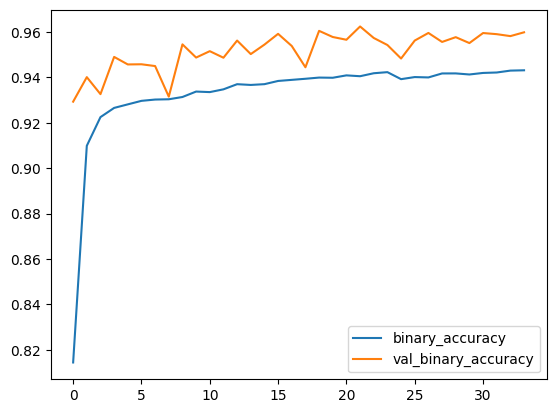

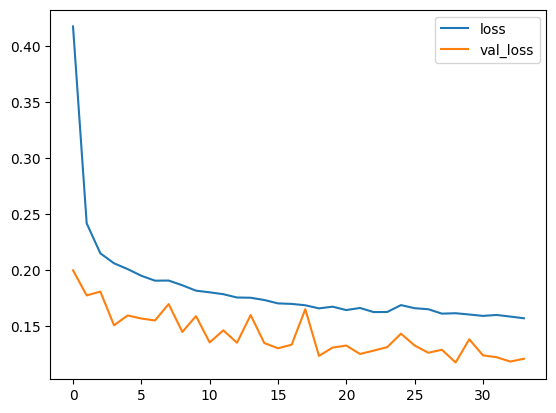

In [ ]:
history.loc[:,['binary_accuracy','val_binary_accuracy']].plot()
history.loc[:,['loss','val_loss']].plot()

In [ ]:
model.evaluate(X_test,y_test)

1097/1097 [==============================] - 2s 2ms/step - loss: 0.1299 - binary_accuracy: 0.9551


[0.12991587817668915, 0.9551234245300293]

Mô hình đã đạt độ chính xác cao, không có hiện tượng chênh lệch quá lớn giữa accuracy train và validation.

In [ ]:
urls_corpus[urls_corpus['label']==1]

,url,label
1,http://www.amicidelgiocodelponte.it/ck.htm,1
2,http://www.beriva.lt/index.html?di=akcijos&V=1...,1
3,http://www.abertosp.com/index.php,1
5,http://mascoterossolidarios.org/index.php?opti...,1
6,http://www.schybirockt.ch/guestbook.html?start=60,1
...,...,...
175360,http://www.tandemimmobilier.fr/index.php?optio...,1
175361,http://www.aptik.or.id/warta-aptik/warta-aptik...,1
175362,http://solutionsplushelp.com/class-schedule-20...,1
175364,http://www.musictomyearscampaign.org/about-mtm...,1


In [ ]:
link=['http://www.beriva.lt/index.html?di=akcijos&V','http://www.amicidelgiocodelponte.it/ck.htm','https://www.youtube.com/watch?v=jfKfPfyJRdk','https://study4.com/tests/?term=ETS'
,'https://drive.google.com/drive/u/0/my-drive','https://genshin.hoyoverse.com/vi/gift','https://www.google.com/?hl=vi','http://1337x.to/torrent/1048648/American-Sniper-2014-MD-iTALiAN-DVDSCR-X264-BST-MT/','https://www.youtube.com/?app=desktop','https://www.youtube.com/watch?v=EzNyPTVnblQ','https://www.kaggle.com/datasets/sid321axn/malicious-urls-dataset']
link=pd.DataFrame(link,columns=['url'])
link

,url
0,http://www.beriva.lt/index.html?di=akcijos&V
1,http://www.amicidelgiocodelponte.it/ck.htm
2,https://www.youtube.com/watch?v=jfKfPfyJRdk
3,https://study4.com/tests/?term=ETS
4,https://drive.google.com/drive/u/0/my-drive
5,https://genshin.hoyoverse.com/vi/gift
6,https://www.google.com/?hl=vi
7,http://1337x.to/torrent/1048648/American-Snipe...
8,https://www.youtube.com/?app=desktop
9,https://www.youtube.com/watch?v=EzNyPTVnblQ


In [ ]:
data=link

In [ ]:
data['url_len']=data['url'].apply(lambda x: len(str(x)))
data['domain']=data['url'].apply(lambda x: get_domain(x))
chars=['@','?','-','=','.','#','%','+','$','!','*',',','//']
for char in chars:
    data[char]=data['url'].apply(lambda x: x.count(char))
data['abnormal_url']=data['url'].apply(lambda x: abnormal_url(x))
data['https']=data['url'].apply(lambda x: http_secure(x))
data['digits']=data['url'].apply(lambda x: digit_count(x))
data['letters']=data['url'].apply(lambda x: letter_count(x))
data['shortening_service']=data['url'].apply(lambda x: find_shortening_service(x))
data['contain_ip_address']=data['url'].apply(lambda x: contain_ip_address(x))
data

,url,url_len,domain,@,?,-,=,.,#,%,...,!,*,",",//,abnormal_url,https,digits,letters,shortening_service,contain_ip_address
0,http://www.beriva.lt/index.html?di=akcijos&V,44,www.beriva.lt,0,1,0,1,3,0,0,...,0,0,0,1,1,0,0,34,0,0
1,http://www.amicidelgiocodelponte.it/ck.htm,42,www.amicidelgiocodelponte.it,0,0,0,0,3,0,0,...,0,0,0,1,1,0,0,35,0,0
2,https://www.youtube.com/watch?v=jfKfPfyJRdk,43,www.youtube.com,0,1,0,1,2,0,0,...,0,0,0,1,1,1,0,35,0,0
3,https://study4.com/tests/?term=ETS,34,study4.com,0,1,0,1,1,0,0,...,0,0,0,1,1,1,1,25,0,0
4,https://drive.google.com/drive/u/0/my-drive,43,drive.google.com,0,0,1,0,2,0,0,...,0,0,0,1,1,1,1,32,0,0
5,https://genshin.hoyoverse.com/vi/gift,37,genshin.hoyoverse.com,0,0,0,0,2,0,0,...,0,0,0,1,1,1,0,30,0,0
6,https://www.google.com/?hl=vi,29,www.google.com,0,1,0,1,2,0,0,...,0,0,0,1,1,1,0,21,0,0
7,http://1337x.to/torrent/1048648/American-Snipe...,83,1337x.to,0,0,8,0,1,0,0,...,0,0,0,1,1,0,18,49,0,0
8,https://www.youtube.com/?app=desktop,36,www.youtube.com,0,1,0,1,2,0,0,...,0,0,0,1,1,1,0,28,0,0
9,https://www.youtube.com/watch?v=EzNyPTVnblQ,43,www.youtube.com,0,1,0,1,2,0,0,...,0,0,0,1,1,1,0,35,0,0


In [ ]:
data=data.drop(columns=['url','domain'],axis=1)
data

,url_len,@,?,-,=,.,#,%,+,$,!,*,",",//,abnormal_url,https,digits,letters,shortening_service,contain_ip_address
0,44,0,1,0,1,3,0,0,0,0,0,0,0,1,1,0,0,34,0,0
1,42,0,0,0,0,3,0,0,0,0,0,0,0,1,1,0,0,35,0,0
2,43,0,1,0,1,2,0,0,0,0,0,0,0,1,1,1,0,35,0,0
3,34,0,1,0,1,1,0,0,0,0,0,0,0,1,1,1,1,25,0,0
4,43,0,0,1,0,2,0,0,0,0,0,0,0,1,1,1,1,32,0,0
5,37,0,0,0,0,2,0,0,0,0,0,0,0,1,1,1,0,30,0,0
6,29,0,1,0,1,2,0,0,0,0,0,0,0,1,1,1,0,21,0,0
7,83,0,0,8,0,1,0,0,0,0,0,0,0,1,1,0,18,49,0,0
8,36,0,1,0,1,2,0,0,0,0,0,0,0,1,1,1,0,28,0,0
9,43,0,1,0,1,2,0,0,0,0,0,0,0,1,1,1,0,35,0,0


In [ ]:
data.shape

(11, 20)

In [ ]:
y_pred=model.predict(data)
y_pred

1/1 [==============================] - 0s 20ms/step


array([[0.9977215 ],
       [0.9975042 ],
       [0.01452936],
       [0.01298384],
       [0.02031535],
       [0.01599664],
       [0.01261552],
       [0.07565102],
       [0.01353913],
       [0.01452936],
       [0.02779561]], dtype=float32)

Kết quả kiểm định thực tế cho ra kết quả khá khả quan.

In [ ]:
for i in range(len(y_pred)):
  if y_pred[i]<0.5:
    print(link.loc[i,'url'],'benign')
  else:
    print(link.loc[i,'url'],'phishing')

Lưu model

In [ ]:
model.save('/content/drive/MyDrive/dataset/20feature.keras')

## Character Embedding trích xuất đặc trưng

Tạo đối tượng Tokenizer huấn luyện URL để hình thành từ điển kí tự của tập dữ liệu.

In [10]:
tokenizer=Tokenizer(oov_token='<OOV>',char_level=True)
tokenizer.fit_on_texts(urls_corpus['url'])
word_index=tokenizer.word_index
word_index

{'<OOV>': 1,
 't': 2,
 'e': 3,
 'o': 4,
 'i': 5,
 '/': 6,
 'a': 7,
 'n': 8,
 'p': 9,
 'c': 10,
 'r': 11,
 's': 12,
 'd': 13,
 'h': 14,
 'l': 15,
 'm': 16,
 '.': 17,
 '-': 18,
 'w': 19,
 '%': 20,
 '=': 21,
 'b': 22,
 'u': 23,
 'g': 24,
 '1': 25,
 '&': 26,
 '0': 27,
 ':': 28,
 '2': 29,
 'f': 30,
 '8': 31,
 'v': 32,
 'k': 33,
 '9': 34,
 'y': 35,
 '3': 36,
 '5': 37,
 '4': 38,
 'x': 39,
 '7': 40,
 '6': 41,
 '_': 42,
 '?': 43,
 'z': 44,
 'j': 45,
 'q': 46,
 '+': 47,
 'ะ': 48,
 '\\': 49,
 ';': 50,
 ',': 51,
 '[': 52,
 ']': 53,
 'พ': 54,
 'ต': 55,
 'ฝ': 56,
 '*': 57,
 '~': 58,
 ')': 59,
 '(': 60,
 'ธ': 61,
 'ฐ': 62,
 'ร': 63,
 "'": 64,
 '@': 65,
 'ผ': 66,
 'บ': 67,
 '|': 68,
 'ฒ': 69,
 'ฑ': 70,
 'ณ': 71,
 'ฟ': 72,
 'ป': 73,
 'ฮ': 74,
 'น': 75,
 '!': 76,
 'ฃ': 77,
 'ด': 78,
 'ก': 79,
 'เ': 80,
 'ย': 81,
 'ท': 82,
 'ฉ': 83,
 'ถ': 84,
 'ญ': 85,
 'ง': 86,
 'า': 87,
 'ค': 88,
 '#': 89,
 'ล': 90,
 '\xa0': 91,
 'ช': 92,
 'ฦ': 93,
 ' ': 94,
 'ฅ': 95,
 '$': 96,
 'ห': 97,
 'จ': 98,
 '{': 99,
 '}': 100,


In [ ]:
len_dictionary=len(tokenizer.word_index)
print(len_dictionary)

138


Lưu từ điển

In [ ]:
with open('/content/drive/MyDrive/Model/tokenizer_char_urls4_17k.pkl','wb') as handle:
  pickle.dump(tokenizer,handle)


In [ ]:
with open('/content/drive/MyDrive/Model/tokenizer_char_urls4_17k.pkl','rb') as handle:
  tokenizer=pickle.load(handle)


In [ ]:
tokenizer.index_word

{1: '<OOV>',
 2: 't',
 3: 'e',
 4: 'o',
 5: 'i',
 6: '/',
 7: 'a',
 8: 'n',
 9: 'p',
 10: 'c',
 11: 'r',
 12: 's',
 13: 'd',
 14: 'h',
 15: 'l',
 16: 'm',
 17: '.',
 18: '-',
 19: 'w',
 20: '%',
 21: '=',
 22: 'b',
 23: 'u',
 24: 'g',
 25: '1',
 26: '&',
 27: '0',
 28: ':',
 29: '2',
 30: 'f',
 31: '8',
 32: 'v',
 33: 'k',
 34: '9',
 35: 'y',
 36: '3',
 37: '5',
 38: '4',
 39: 'x',
 40: '7',
 41: '6',
 42: '_',
 43: '?',
 44: 'z',
 45: 'j',
 46: 'q',
 47: '+',
 48: 'ะ',
 49: '\\',
 50: ';',
 51: ',',
 52: '[',
 53: ']',
 54: 'พ',
 55: 'ต',
 56: 'ฝ',
 57: '*',
 58: '~',
 59: ')',
 60: '(',
 61: 'ธ',
 62: 'ฐ',
 63: 'ร',
 64: "'",
 65: '@',
 66: 'ผ',
 67: 'บ',
 68: '|',
 69: 'ฒ',
 70: 'ฑ',
 71: 'ณ',
 72: 'ฟ',
 73: 'ป',
 74: 'ฮ',
 75: 'น',
 76: '!',
 77: 'ฃ',
 78: 'ด',
 79: 'ก',
 80: 'เ',
 81: 'ย',
 82: 'ท',
 83: 'ฉ',
 84: 'ถ',
 85: 'ญ',
 86: 'ง',
 87: 'า',
 88: 'ค',
 89: '#',
 90: 'ล',
 91: '\xa0',
 92: 'ช',
 93: 'ฦ',
 94: ' ',
 95: 'ฅ',
 96: '$',
 97: 'ห',
 98: 'จ',
 99: '{',
 100: '}',


Khai báo các tham số sử dụng trong embedding

In [11]:
len_dictionary=138
maxlen=300
embedding_dims=32

In [ ]:
token=tokenizer.texts_to_sequences(urls_corpus['url'])

In [ ]:
max=0
for t in token:
  if len(t)>max:
    max=len(t)
print(max)

2081


In [ ]:
token = pad_sequences(token, maxlen=maxlen, padding='post',truncating='post')

In [ ]:
token.shape

(175366, 300)

Tạo hàm tạo model Embedding

In [ ]:
from keras.layers import BatchNormalization, Dropout, LSTM, Conv1D, AveragePooling1D, InputLayer, GlobalAveragePooling1D, SpatialDropout1D

def create_embedding(size_label=5):
    model = keras.Sequential([
    Embedding(len_dictionary,embedding_dims,input_length=maxlen),
    Flatten(),
    Dense(10,activation='relu'),
    Dense(size_label, activation='softmax'),
    ])
    return model

In [ ]:
token.shape

(175366, 300)

In [ ]:
model=create_embedding(size_label=5)
model.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 32)           4416      
                                                                 
 flatten (Flatten)           (None, 9600)              0         
                                                                 
 dense (Dense)               (None, 10)                96010     
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
Total params: 100481 (392.50 KB)
Trainable params: 100481 (392.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Phân chia dữ liệu

In [ ]:
X=token
y=urls_corpus['label']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train.shape,X_test.shape

((140292, 300), (35074, 300))

In [ ]:
earlystopping = keras.callbacks.EarlyStopping(monitor ="val_loss",
                                        mode ="min", patience =3,
                                        restore_best_weights = True)

In [ ]:
folder='/content/drive/MyDrive/Model/'
checkpoint=tf.keras.callbacks.ModelCheckpoint(
    filepath=folder+'p1_300_embedding_epoch_{epoch:02d}_val_acc_{val_accuracy:.2f}.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

In [ ]:
history=model.fit(X_train,y_train,epochs=40,validation_split=0.2,verbose=1,callbacks=[earlystopping,checkpoint])

Epoch 1/40
3508/3508 [==============================] - 20s 5ms/step - loss: 0.1795 - accuracy: 0.9431 - val_loss: 0.0821 - val_accuracy: 0.9741
Epoch 2/40
  46/3508 [..............................] - ETA: 11s - loss: 0.0483 - accuracy: 0.9871

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3508/3508 [==============================] - 16s 4ms/step - loss: 0.0669 - accuracy: 0.9791 - val_loss: 0.0690 - val_accuracy: 0.9794
Epoch 3/40
3508/3508 [==============================] - 16s 5ms/step - loss: 0.0474 - accuracy: 0.9849 - val_loss: 0.0640 - val_accuracy: 0.9814
Epoch 4/40
3508/3508 [==============================] - 15s 4ms/step - loss: 0.0362 - accuracy: 0.9883 - val_loss: 0.0693 - val_accuracy: 0.9811
Epoch 5/40
3508/3508 [==============================] - 15s 4ms/step - loss: 0.0289 - accuracy: 0.9906 - val_loss: 0.0707 - val_accuracy: 0.9814
Epoch 6/40
3508/3508 [==============================] - 14s 4ms/step - loss: 0.0243 - accuracy: 0.9923 - val_loss: 0.0757 - val_accuracy: 0.9814


In [ ]:
checkpoint=tf.keras.callbacks.ModelCheckpoint(
    filepath=folder+'p2_300_embedding_epoch_{epoch:02d}_val_acc_{val_accuracy:.2f}.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

In [ ]:
history2 = model.fit(X_train,y_train,epochs=40,validation_split=0.2,verbose=1,callbacks=[earlystopping,checkpoint])

Epoch 1/40
3508/3508 [==============================] - 15s 4ms/step - loss: 0.0367 - accuracy: 0.9886 - val_loss: 0.0649 - val_accuracy: 0.9826
Epoch 2/40
3508/3508 [==============================] - 14s 4ms/step - loss: 0.0302 - accuracy: 0.9904 - val_loss: 0.0690 - val_accuracy: 0.9825
Epoch 3/40
3508/3508 [==============================] - 15s 4ms/step - loss: 0.0239 - accuracy: 0.9924 - val_loss: 0.0798 - val_accuracy: 0.9822
Epoch 4/40
3508/3508 [==============================] - 15s 4ms/step - loss: 0.0206 - accuracy: 0.9936 - val_loss: 0.0842 - val_accuracy: 0.9804


In [ ]:
history=pd.concat([pd.DataFrame(history.history),pd.DataFrame(history2.history)],axis=0).reset_index()
history

,index,loss,accuracy,val_loss,val_accuracy
0,0,0.179491,0.943092,0.082129,0.974090
1,1,0.066947,0.979142,0.069036,0.979365
2,2,0.047363,0.984880,0.063993,0.981361
3,3,0.036206,0.988346,0.069321,0.981147
4,4,0.028920,0.990573,0.070697,0.981432
5,5,0.024293,0.992346,0.075678,0.981361
6,0,0.036730,0.988551,0.064878,0.982608
7,1,0.030196,0.990431,0.068978,0.982537
8,2,0.023926,0.992426,0.079829,0.982180
9,3,0.020650,0.993585,0.084206,0.980398


<Axes: >

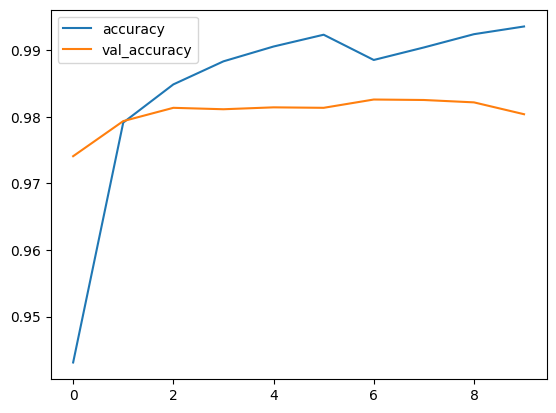

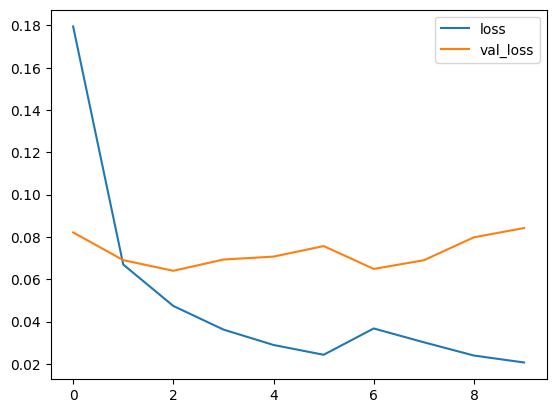

In [ ]:
history.loc[:,['accuracy','val_accuracy']].plot()
history.loc[:,['loss','val_loss']].plot()

In [ ]:
model.evaluate(X_test,y_test)

1097/1097 [==============================] - 2s 2ms/step - loss: 0.0710 - accuracy: 0.9807


[0.07100891321897507, 0.9807264804840088]

Kết quả cho thấy mô hình đã đạt hiệu quả cao trong việc học đặc trưng

Áp dụng thực tiễn

In [ ]:
# link= ['https://www.youtube.com','https://www.kaggle.com/code/fahaddalwai/detecting-malicious-url-using-neural-network','https://study4.com/tests/?term=ETS']
link=['https://www.youtube.com/','https://www.kaggle.com/code/shujian/blend-of-lstm-and-cnn-with-4-embeddings-1200d','https://study4.com/tests/?term=ETS'
,'https://phamdinhkhanh.github.io/2019/04/22/Ly_thuyet_ve_mang_LSTM.html','https://drive.google.com/drive/u/0/my-drive','https://genshin.hoyoverse.com/vi/gift','https://www.google.com/?hl=vi','http://1337x.to/torrent/1048648/American-Sniper-2014-MD-iTALiAN-DVDSCR-X264-BST-MT/','https://www.youtube.com/?app=desktop','https://www.youtube.com/watch?v=EzNyPTVnblQ','https://www.kaggle.com/datasets/sid321axn/malicious-urls-dataset']

link=pd.DataFrame(link,columns=['url'])
link

,url
0,https://www.youtube.com/
1,https://www.kaggle.com/code/shujian/blend-of-l...
2,https://study4.com/tests/?term=ETS
3,https://phamdinhkhanh.github.io/2019/04/22/Ly_...
4,https://drive.google.com/drive/u/0/my-drive
5,https://genshin.hoyoverse.com/vi/gift
6,https://www.google.com/?hl=vi
7,http://1337x.to/torrent/1048648/American-Snipe...
8,https://www.youtube.com/?app=desktop
9,https://www.youtube.com/watch?v=EzNyPTVnblQ


In [ ]:
data= tokenizer.texts_to_sequences(link['url'])
data= pad_sequences(data, maxlen=maxlen, padding='post',truncating='post')


In [ ]:
y_pred=model.predict(data)
y_pred

1/1 [==============================] - 0s 27ms/step


array([[9.9999487e-01, 8.6213066e-07, 5.6266629e-08, 4.2517058e-06,
        2.0813622e-09],
       [1.0000000e+00, 5.3349920e-12, 5.2803739e-09, 3.1157694e-12,
        1.2641699e-10],
       [9.9416542e-01, 3.2829892e-09, 9.5316798e-05, 5.7391827e-03,
        5.4933004e-08],
       [4.6263087e-01, 1.0431458e-07, 1.7253003e-01, 7.8740895e-02,
        2.8609815e-01],
       [9.7277755e-01, 1.6235323e-06, 1.4614543e-03, 2.5757540e-02,
        1.8358472e-06],
       [9.9981958e-01, 1.1563202e-09, 1.5173690e-07, 1.8017768e-04,
        7.0126681e-08],
       [9.9999928e-01, 6.9310859e-09, 1.5894194e-11, 7.7240418e-07,
        1.1645709e-11],
       [9.9986804e-01, 9.7006043e-05, 2.3810449e-05, 6.8070299e-06,
        4.3303694e-06],
       [9.9998641e-01, 8.4470813e-08, 3.4939312e-08, 1.3397696e-05,
        9.7720487e-10],
       [9.9994338e-01, 9.0086850e-08, 5.8215718e-08, 5.6497876e-05,
        5.7059185e-10],
       [1.0000000e+00, 4.9211807e-10, 9.0839736e-09, 2.1549966e-09,
        3.60

In [ ]:
pred_list=np.argmax(y_pred,axis=1)

In [ ]:
for i in range(len(pred_list)):
  print(label[pred_list[i]],link.loc[i,'url'])

benign https://www.youtube.com/
benign https://www.kaggle.com/code/shujian/blend-of-lstm-and-cnn-with-4-embeddings-1200d
benign https://study4.com/tests/?term=ETS
benign https://phamdinhkhanh.github.io/2019/04/22/Ly_thuyet_ve_mang_LSTM.html
benign https://drive.google.com/drive/u/0/my-drive
benign https://genshin.hoyoverse.com/vi/gift
benign https://www.google.com/?hl=vi
benign http://1337x.to/torrent/1048648/American-Sniper-2014-MD-iTALiAN-DVDSCR-X264-BST-MT/
benign https://www.youtube.com/?app=desktop
benign https://www.youtube.com/watch?v=EzNyPTVnblQ
benign https://www.kaggle.com/datasets/sid321axn/malicious-urls-dataset


Mô hình có thể nhận diện được url với hiệu suất khá cao, tiến hành lưu model

In [ ]:
model.save('/content/drive/MyDrive/Model/model_embedding_300.keras')

## CNN1D + LSTM phân loại nhãn URL độc hại

Trích xuất lớp embedding

In [ ]:
embedding_layer=model.get_layer('embedding')
embedding_matrix=embedding_layer.weights[0].numpy()

In [ ]:
embedding_matrix.shape

(138, 32)

Lưu ma trận embedding

In [ ]:
import io
out_v=io.open('/content/drive/MyDrive/Model/vecs.tsv','w',encoding='utf-8')
out_m=io.open('/content/drive/MyDrive/Model/meta.tsv','w',encoding='utf-8')

for idx in range(1,len_dictionary+1):
  word=tokenizer.index_word[idx]
  vector=embedding_matrix[idx-1]
  if idx==91:
    word='space'
  elif idx==94:
    word='space2'
  out_m.write(word+"\n")
  out_v.write('\t'.join([str(x) for x in vector])+"\n")
out_m.close()
out_v.close()

Tạo một model trích xuất đặc trưng của URL

In [ ]:
from keras.layers import GlobalAveragePooling1D

In [ ]:
model=Sequential()

In [ ]:
model.add(Embedding(len_dictionary,embedding_dims,input_length=maxlen,weights=[embedding_matrix]))

model.add(GlobalAveragePooling1D())

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 32)           4416      
                                                                 
 global_average_pooling1d (  (None, 32)                0         
 GlobalAveragePooling1D)                                         
                                                                 
Total params: 4416 (17.25 KB)
Trainable params: 4416 (17.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Lưu mô hình

In [ ]:
model.save('/content/drive/MyDrive/Model/feature_character.keras')

In [ ]:
model= keras.models.load_model('/content/drive/MyDrive/Model/feature_character.keras')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 32)           4416      
                                                                 
 global_average_pooling1d (  (None, 32)                0         
 GlobalAveragePooling1D)                                         
                                                                 
Total params: 4416 (17.25 KB)
Trainable params: 4416 (17.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Tạo dataframe slice để lưu trữ kết quả các phép tách của URL

In [ ]:
slice_data=urls_corpus.loc[:,'url']
slice_data=slice_data.to_frame(name='url')

In [ ]:
slice_data

,url
0,http://amber.ch.ic.ac.uk/archive/all/5075.html
1,http://www.amicidelgiocodelponte.it/ck.htm
2,http://www.beriva.lt/index.html?di=akcijos&V=1...
3,http://www.abertosp.com/index.php
4,http://rocketnews24.com/tag/%e3%82%bd%e3%82%a6...
...,...
175361,http://www.aptik.or.id/warta-aptik/warta-aptik...
175362,http://solutionsplushelp.com/class-schedule-20...
175363,http://techcrunch.com/2015/05/12/mozilla-launc...
175364,http://www.musictomyearscampaign.org/about-mtm...


Tạo hàm phân tách các thành phần trong URL

In [ ]:
def protocol(url):
    result=urlparse(url)
    return result.scheme
def sub_domain(url):
    domain=tldextract.extract(url)
    return domain.subdomain
def domain(url):
    domain=tldextract.extract(url)
    return domain.domain
def suffix(url):
    domain=tldextract.extract(url)
    return domain.suffix
def path(url):
    result=urlparse(url)
    return result.path

In [ ]:
slice_data['protocol_url']=slice_data['url'].apply(lambda x: protocol(x))
slice_data['sub_domain_url']=slice_data['url'].apply(lambda x: sub_domain(x))
slice_data['domain_url']=slice_data['url'].apply(lambda x: domain(x))
slice_data['suffix_domain_url']=slice_data['url'].apply(lambda x: suffix(x))
slice_data['path_url']=slice_data['url'].apply(lambda x: path(x))
slice_data.head(1)

,url,protocol_url,sub_domain_url,domain_url,suffix_domain_url,path_url
0,http://amber.ch.ic.ac.uk/archive/all/5075.html,http,amber.ch,ic,ac.uk,/archive/all/5075.html


Lưu data slice corpus

In [ ]:
slice_data.to_csv('/content/drive/MyDrive/dataset/SLICE_CORPUS.csv',index=False)

In [ ]:
# slice_data=pd.read_csv('/content/drive/MyDrive/Model3/SLICE_DATA4.csv')

In [ ]:
# slice_data['protocol_url'].fillna('',inplace=True)
# slice_data['sub_domain_url'].fillna('',inplace=True)
# slice_data['domain_url'].fillna('',inplace=True)
# slice_data['suffix_domain_url'].fillna('',inplace=True)
# slice_data['path_url'].fillna('',inplace=True)

In [ ]:
slice_data.isnull().sum()

url                  0
protocol_url         0
sub_domain_url       0
domain_url           0
suffix_domain_url    0
path_url             0
dtype: int64

Tạo hàm trích xuất đặc trưng theo từng phần

In [ ]:
def get_feature(data):
  temp_data = tokenizer.texts_to_sequences(data)
  temp_data = pad_sequences(temp_data, maxlen=maxlen, padding='post',truncating='post')
  feature=model.predict(temp_data)

  del(temp_data)
  return feature


In [ ]:
slice_data.head(5)

,url,protocol_url,sub_domain_url,domain_url,suffix_domain_url,path_url
0,http://amber.ch.ic.ac.uk/archive/all/5075.html,http,amber.ch,ic,ac.uk,/archive/all/5075.html
1,http://www.amicidelgiocodelponte.it/ck.htm,http,www,amicidelgiocodelponte,it,/ck.htm
2,http://www.beriva.lt/index.html?di=akcijos&V=1...,http,www,beriva,lt,/index.html
3,http://www.abertosp.com/index.php,http,www,abertosp,com,/index.php
4,http://rocketnews24.com/tag/%e3%82%bd%e3%82%a6...,http,,rocketnews24,com,/tag/%e3%82%bd%e3%82%a6%e3%83%ab%e3%83%9e%e3%8...


In [ ]:
feature=get_feature(slice_data['protocol_url'])
feature2=get_feature(slice_data['sub_domain_url'])
feature3=get_feature(slice_data['domain_url'])
feature4=get_feature(slice_data['suffix_domain_url'])
feature5=get_feature(slice_data['path_url'])

5481/5481 [==============================] - 7s 1ms/step


In [ ]:
feature=np.concatenate((feature,feature2,feature3,feature4,feature5),axis=1)
feature.shape

(175366, 160)

In [ ]:
del(feature2)
del(feature3)
del(feature4)
del(feature5)

Nối các feature và chuyền vào một đối tượng DataFrame

In [ ]:
feature=pd.DataFrame(feature,columns=['f'+str(x)for x in range(1,feature.shape[1]+1)])
feature.head(1)

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f151,f152,f153,f154,f155,f156,f157,f158,f159,f160
0,-0.001086,0.001335,0.006024,-0.000409,0.000985,0.001528,-0.002369,-0.002007,-0.002298,0.000764,...,-0.000008,-0.004915,-0.002084,-0.006561,-0.009637,0.006741,-0.007565,0.004202,-0.008325,-0.009864


In [ ]:
feature.to_csv('/content/drive/MyDrive/dataset/F_DATA.csv',index=False)

In [ ]:
feature.shape, y.shape

((175366, 160), (175366,))

Tạo ma trận tương quan cho thấy sự tương quan giữa các đặc trưng với nhãn

In [ ]:
corr_data=pd.concat([feature,y],axis=1)

In [ ]:
corr_data.corr()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f152,f153,f154,f155,f156,f157,f158,f159,f160,label
f1,1.000000,-0.941773,0.553775,-0.750186,0.503830,0.331230,-0.539199,0.681233,-0.684243,0.580848,...,0.030426,0.039345,0.051356,0.026144,-0.006681,0.057846,0.010091,0.012120,0.025085,-0.216202
f2,-0.941773,1.000000,-0.789923,0.806295,-0.713146,-0.190920,0.675229,-0.472847,0.452389,-0.670465,...,-0.034060,-0.043404,-0.056175,-0.027173,0.009571,-0.064825,-0.013931,-0.004733,-0.026745,0.234639
f3,0.553775,-0.789923,1.000000,-0.792268,0.959425,0.101277,-0.855531,0.100358,0.161631,0.786022,...,0.040273,0.043583,0.058067,0.024369,-0.017725,0.068686,0.021746,-0.021313,0.026103,-0.227197
f4,-0.750186,0.806295,-0.792268,1.000000,-0.875051,-0.654505,0.951820,-0.672598,0.126649,-0.973287,...,-0.054121,-0.051880,-0.073106,-0.031367,0.023526,-0.082688,-0.025641,0.027320,-0.033530,0.274082
f5,0.503830,-0.713146,0.959425,-0.875051,1.000000,0.334000,-0.957488,0.249031,0.259460,0.908370,...,0.048839,0.046955,0.065102,0.026159,-0.023234,0.075712,0.026252,-0.033518,0.028946,-0.244055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
f157,0.057846,-0.064825,0.068686,-0.082688,0.075712,0.052406,-0.081027,0.050757,-0.003331,0.081913,...,-0.136296,0.792209,0.757807,0.709569,-0.683277,1.000000,-0.589891,-0.093719,0.842660,0.074639
f158,0.010091,-0.013931,0.021746,-0.025641,0.026252,0.019605,-0.028394,0.013002,0.009791,0.028188,...,0.404011,-0.506876,-0.721239,-0.750509,0.314303,-0.589891,1.000000,-0.414651,-0.704230,-0.088445
f159,0.012120,-0.004733,-0.021313,0.027320,-0.033518,-0.033970,0.038664,-0.009310,-0.039725,-0.037960,...,-0.318405,-0.148967,0.080981,0.178329,0.181084,-0.093719,-0.414651,1.000000,0.064141,-0.094234
f160,0.025085,-0.026745,0.026103,-0.033530,0.028946,0.022509,-0.031774,0.022978,-0.004676,0.032613,...,-0.213159,0.847036,0.816770,0.856511,-0.663778,0.842660,-0.704230,0.064141,1.000000,0.114775


Chia tập test và train

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(feature, urls_corpus['label'], test_size=0.2, random_state=42)

In [ ]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((140292, 160), (140292,), (35074, 160), (35074,))

Tạo mô hình CNN

In [ ]:
import os
import numpy as np
import os
import time
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout,Conv1D,MaxPooling1D,Flatten,LSTM, BatchNormalization
import itertools
def create_cnn_lstm_model(input_shape,size_label=5):
    model=Sequential([
        Conv1D(16,3,padding='same',activation='relu',input_shape=input_shape),
        MaxPooling1D(pool_size=2),

        Conv1D(32,3,padding='same',activation='relu'),
        MaxPooling1D(pool_size=2),

        Conv1D(16,3,padding='same',activation='relu'),
        MaxPooling1D(pool_size=2),

        LSTM(100),
        Dropout(0.3),
        Dense(16,activation='relu'),
        Dropout(0.3),
        Dense(size_label,activation='softmax')
    ])
    return model
# def create_cnn_lstm_model2(input_shape,size_label=42):
#     model = keras.Sequential([
#     BatchNormalization(input_shape=input_shape),
#     Conv1D(filters=64,kernel_size=7,activation='relu'),
#     BatchNormalization(),
#     #layers.Conv1D(filters=32,kernel_size=3,activation='relu'),
#     #layers.BatchNormalization(),
#     MaxPooling1D(pool_size=2) ,
#     Dropout(0.3),

#     LSTM(100),
#     Dropout(0.3),
#     Flatten(), # flatten out the layers
#     Dense(512,activation='relu'),
#     BatchNormalization(),
#     Dropout(0.3),
#     Dense(512,activation='relu'),
#     BatchNormalization(),
#     Dropout(0.3),
#     Dense(size_label, activation='softmax'),
#     ])
#     return model

In [ ]:
model=create_cnn_lstm_model((X_train.shape[1],1),5)
model.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.optimizers.Adam(learning_rate=0.001),
                metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 160, 16)           64        
                                                                 
 max_pooling1d_9 (MaxPoolin  (None, 80, 16)            0         
 g1D)                                                            
                                                                 
 conv1d_10 (Conv1D)          (None, 80, 32)            1568      
                                                                 
 max_pooling1d_10 (MaxPooli  (None, 40, 32)            0         
 ng1D)                                                           
                                                                 
 conv1d_11 (Conv1D)          (None, 40, 16)            1552      
                                                                 
 max_pooling1d_11 (MaxPooli  (None, 20, 16)           

In [ ]:
folder=r'/content/drive/MyDrive/Model/'
checkpoint=tf.keras.callbacks.ModelCheckpoint(
    filepath=folder+'part1_cnn_lstm_epoch_{epoch:02d}_val_acc_{val_accuracy:.2f}.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

In [ ]:
earlystopping = keras.callbacks.EarlyStopping(monitor ="val_loss",
                                        mode ="min", patience =5,
                                        restore_best_weights = True)

In [ ]:
history=model.fit(X_train,y_train,
            epochs=50,
            validation_split=0.2,
            validation_freq=1,
            callbacks=[earlystopping,checkpoint])

Epoch 1/50
3508/3508 [==============================] - 35s 8ms/step - loss: 0.8085 - accuracy: 0.7302 - val_loss: 0.5078 - val_accuracy: 0.8252
Epoch 2/50
  19/3508 [..............................] - ETA: 20s - loss: 0.5677 - accuracy: 0.8191

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3508/3508 [==============================] - 26s 7ms/step - loss: 0.5503 - accuracy: 0.8167 - val_loss: 0.3927 - val_accuracy: 0.8594
Epoch 3/50
3508/3508 [==============================] - 27s 8ms/step - loss: 0.4042 - accuracy: 0.8652 - val_loss: 0.3630 - val_accuracy: 0.8735
Epoch 4/50
3508/3508 [==============================] - 27s 8ms/step - loss: 0.3308 - accuracy: 0.8909 - val_loss: 0.2497 - val_accuracy: 0.9185
Epoch 5/50
3508/3508 [==============================] - 25s 7ms/step - loss: 0.2819 - accuracy: 0.9099 - val_loss: 0.2450 - val_accuracy: 0.9211
Epoch 6/50
3508/3508 [==============================] - 26s 7ms/step - loss: 0.2451 - accuracy: 0.9234 - val_loss: 0.1821 - val_accuracy: 0.9426
Epoch 7/50
3508/3508 [==============================] - 26s 7ms/step - loss: 0.2128 - accuracy: 0.9332 - val_loss: 0.1748 - val_accuracy: 0.9407
Epoch 8/50
3508/3508 [==============================] - 26s 7ms/step - loss: 0.1929 - accuracy: 0.9410 - val_loss: 0.1387 - val_accuracy: 0.9

In [ ]:
checkpoint=tf.keras.callbacks.ModelCheckpoint(
    filepath=folder+'p2_cnn_lstm_epoch_{epoch:02d}_val_acc_{val_accuracy:.2f}.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

In [ ]:
history2=model.fit(X_train,y_train,
            epochs=50,
            validation_split=0.2,
            validation_freq=1,
            callbacks=[earlystopping,checkpoint])

Epoch 1/50
3508/3508 [==============================] - 26s 7ms/step - loss: 0.0684 - accuracy: 0.9795 - val_loss: 0.0864 - val_accuracy: 0.9759
Epoch 2/50
  19/3508 [..............................] - ETA: 20s - loss: 0.0725 - accuracy: 0.9770

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3508/3508 [==============================] - 26s 7ms/step - loss: 0.0696 - accuracy: 0.9796 - val_loss: 0.0711 - val_accuracy: 0.9807
Epoch 3/50
3508/3508 [==============================] - 27s 8ms/step - loss: 0.0718 - accuracy: 0.9791 - val_loss: 0.0873 - val_accuracy: 0.9737
Epoch 4/50
3508/3508 [==============================] - 28s 8ms/step - loss: 0.0658 - accuracy: 0.9807 - val_loss: 0.0673 - val_accuracy: 0.9809
Epoch 5/50
3508/3508 [==============================] - 25s 7ms/step - loss: 0.0652 - accuracy: 0.9811 - val_loss: 0.0531 - val_accuracy: 0.9846
Epoch 6/50
3508/3508 [==============================] - 26s 7ms/step - loss: 0.0621 - accuracy: 0.9819 - val_loss: 0.0606 - val_accuracy: 0.9830
Epoch 7/50
3508/3508 [==============================] - 26s 7ms/step - loss: 0.0571 - accuracy: 0.9829 - val_loss: 0.0608 - val_accuracy: 0.9833
Epoch 8/50
3508/3508 [==============================] - 26s 7ms/step - loss: 0.0566 - accuracy: 0.9831 - val_loss: 0.0510 - val_accuracy: 0.9

In [ ]:
history=pd.concat([pd.DataFrame(history.history),pd.DataFrame(history2.history)],axis=0).reset_index()
history

,index,loss,accuracy,val_loss,val_accuracy
0,0,0.808507,0.730204,0.507753,0.825190
1,1,0.550271,0.816747,0.392725,0.859403
2,2,0.404185,0.865209,0.363025,0.873516
3,3,0.330793,0.890905,0.249744,0.918458
4,4,0.281941,0.909920,0.245015,0.921095
5,5,0.245072,0.923365,0.182117,0.942585
6,6,0.212838,0.933201,0.174760,0.940696
7,7,0.192865,0.940980,0.138651,0.958373
8,8,0.167163,0.948607,0.136797,0.958516
9,9,0.150828,0.954523,0.140002,0.958088


<Axes: >

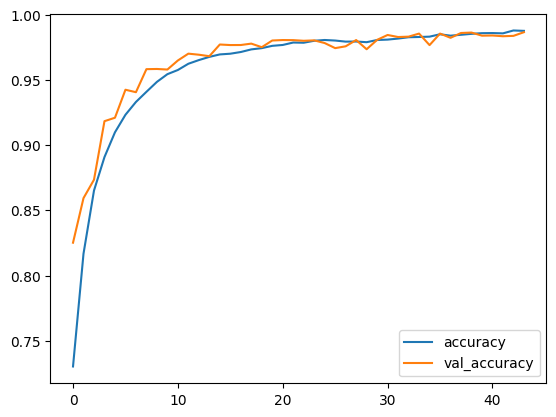

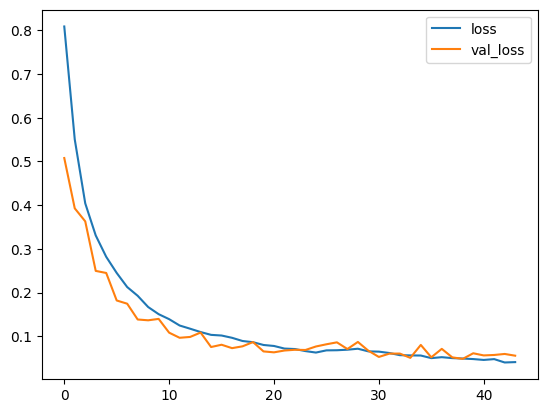

In [ ]:
history.loc[:,['accuracy','val_accuracy']].plot()
history.loc[:,['loss','val_loss']].plot()

In [ ]:
model.evaluate(X_test,y_test)

1097/1097 [==============================] - 4s 4ms/step - loss: 0.0507 - accuracy: 0.9858


[0.05068899318575859, 0.9858299493789673]

Qua kết quả có thể thấy mô hình đã hoạt động khá tốt, không có hiện tượng quá khớp. Tiến hành kiểm định trên các URL thực tế.

In [ ]:
model_test=model

In [31]:
# link= ['https://www.youtube.com','https://www.youtube.com/watch?v=sd14-uIs5jQ','https://drive.google.com/drive/u/0/home','https://www.kaggle.com/code/fahaddalwai/detecting-malicious-url-using-neural-network','https://study4.com/tests/?term=ETS']
# link=['https://safebrowsing.google.com', 'https://us.norton.com/blog/how-to/check-if-a-website-is-safe', 'https://www.sitelock.com/blog/is-this-website-safe', 'https://www.ssltrust.com/ssl-tools/website-security-check', 'https://www.cnet.com/tech/computing/how-to-check-if-a-web-site-is-safe', 'https://www.w3schools.com', 'https://www.wikipedia.org', 'https://www.amazon.com', 'https://www.netflix.com', 'https://www.spotify.com', 'https://www.facebook.com', 'https://www.instagram.com', 'https://www.twitter.com', 'https://www.linkedin.com', 'https://www.pinterest.com', 'https://www.reddit.com', 'https://www.tiktok.com', 'https://www.snapchat.com', 'https://www.whatsapp.com', 'https://www.skype.com', 'https://www.zoom.us', 'https://www.microsoft.com', 'https://www.apple.com', 'https://www.google.com', 'https://www.google.com/', 'https://www.youtube.com','https://www.youtube.com/', 'https://www.bing.com', 'https://www.yahoo.com', 'https://www.paypal.com', 'https://www.ebay.com', 'https://www.etsy.com', 'https://www.airbnb.com', 'https://www.uber.com', 'https://www.lyft.com', 'https://www.starbucks.com', 'https://www.mcdonalds.com', 'https://www.cnn.com', 'https://www.bbc.com', 'https://www.nytimes.com', 'https://www.forbes.com', 'https://www.nationalgeographic.com', 'https://www.nasa.gov', 'https://www.imdb.com', 'https://www.rottentomatoes.com', 'https://www.goodreads.com', 'https://www.quora.com', 'https://www.stackoverflow.com', 'https://www.github.com', 'https://www.khanacademy.org', 'https://www.coursera.org', 'https://www.duolingo.com']
link=['https://colab.research.google.com/drive/1mdR7wKjBbXOvvPCZchNGZy1s18A9Qx7B?authuser=2#scrollTo=041vBLFFKgYo','https://safebrowsing.google.com','https://www.youtube.com/watch?v=jfKfPfyJRdk','https://study4.com/tests/?term=ETS'
,'https://drive.google.com/drive/u/0/my-drive','https://genshin.hoyoverse.com/vi/gift','https://www.google.com/?hl=vi','http://1337x.to/torrent/1048648/American-Sniper-2014-MD-iTALiAN-DVDSCR-X264-BST-MT/','https://www.youtube.com/?app=desktop','https://www.youtube.com/watch?v=EzNyPTVnblQ','https://www.kaggle.com/datasets/sid321axn/malicious-urls-dataset']
link=pd.DataFrame(link,columns=['url'])
link

,url
0,https://colab.research.google.com/drive/1mdR7w...
1,https://safebrowsing.google.com
2,https://www.youtube.com/watch?v=jfKfPfyJRdk
3,https://study4.com/tests/?term=ETS
4,https://drive.google.com/drive/u/0/my-drive
5,https://genshin.hoyoverse.com/vi/gift
6,https://www.google.com/?hl=vi
7,http://1337x.to/torrent/1048648/American-Snipe...
8,https://www.youtube.com/?app=desktop
9,https://www.youtube.com/watch?v=EzNyPTVnblQ


In [ ]:
data=link
data1=pd.DataFrame()

In [ ]:
data1['protocol_url']=data['url'].apply(lambda x: protocol(x))
data1['sub_domain_url']=data['url'].apply(lambda x: sub_domain(x))
data1['domain_url']=data['url'].apply(lambda x: domain(x))
data1['suffix_domain_url']=data['url'].apply(lambda x: suffix(x))
data1['path_url']=data['url'].apply(lambda x: path(x))
data1.head(1)

,protocol_url,sub_domain_url,domain_url,suffix_domain_url,path_url
0,https,colab.research,google,com,/drive/1mdR7wKjBbXOvvPCZchNGZy1s18A9Qx7B


load model trích xuất vector đặc trưng

In [ ]:
model=keras.models.load_model('/content/drive/MyDrive/Model/feature_character.keras')

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 32)           4416      
                                                                 
 global_average_pooling1d (  (None, 32)                0         
 GlobalAveragePooling1D)                                         
                                                                 
Total params: 4416 (17.25 KB)
Trainable params: 4416 (17.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
feature=get_feature(data1['protocol_url'])
feature2=get_feature(data1['sub_domain_url'])
feature3=get_feature(data1['domain_url'])
feature4=get_feature(data1['suffix_domain_url'])
feature5=get_feature(data1['path_url'])

1/1 [==============================] - 0s 15ms/step


In [ ]:
feature=np.concatenate((feature,feature2,feature3,feature4,feature5),axis=1)
feature.shape

(11, 160)

In [ ]:
del(feature2)
del(feature3)
del(feature4)
del(feature5)

In [ ]:
feature=pd.DataFrame(feature,columns=['f'+str(x)for x in range(1,feature.shape[1]+1)])
feature.head(1)

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f151,f152,f153,f154,f155,f156,f157,f158,f159,f160
0,-0.000737,0.000826,0.006213,-0.0017,0.001419,0.00198,-0.003141,-0.001885,-0.002306,0.00157,...,0.007793,0.002734,-0.008488,-0.007016,-0.009171,-0.002943,-0.013814,0.004351,-0.004798,-0.010261


In [ ]:
y_pred=np.argmax(model_test.predict(feature),axis=1)
y_pred

1/1 [==============================] - 1s 510ms/step


array([2, 3, 0, 0, 3, 3, 0, 0, 0, 0, 0])

In [ ]:
for i in range(len(y_pred)):
  print(label[y_pred[i]],link.loc[i,'url'])

malware https://colab.research.google.com/drive/1mdR7wKjBbXOvvPCZchNGZy1s18A9Qx7B?authuser=2#scrollTo=041vBLFFKgYo
phishing https://safebrowsing.google.com
benign https://www.youtube.com/watch?v=jfKfPfyJRdk
benign https://study4.com/tests/?term=ETS
phishing https://drive.google.com/drive/u/0/my-drive
phishing https://genshin.hoyoverse.com/vi/gift
benign https://www.google.com/?hl=vi
benign http://1337x.to/torrent/1048648/American-Sniper-2014-MD-iTALiAN-DVDSCR-X264-BST-MT/
benign https://www.youtube.com/?app=desktop
benign https://www.youtube.com/watch?v=EzNyPTVnblQ
benign https://www.kaggle.com/datasets/sid321axn/malicious-urls-dataset


Mô hình vẫn còn hiện tượng nhìn nhận nhầm lẫn những URL lành tính